In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:,.3f}'.format)
import numpy as np
import time
import itertools
import logging
import random
import warnings

import sktime.forecasting.naive as skt

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tools.sm_exceptions import ValueWarning

import pmdarima as pmd
from pmdarima.arima import auto_arima
from datetime import datetime

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# Prophet spits out a lot of warnings etc.
for name in ("cmdstanpy", "prophet", "prophet.forecaster"):
    lg = logging.getLogger(name)
    lg.setLevel(logging.CRITICAL)   
    lg.propagate = False
    lg.handlers.clear()
    lg.addHandler(logging.NullHandler())


# ETS
warnings.filterwarnings(
    "ignore",
    message=".*unsupported index.*|.*No supported index is available.*",
    category=ValueWarning
)
warnings.filterwarnings(
    "ignore",
    message=".*No supported index is available.*",
    category=FutureWarning
)

In [3]:
# Prevent Win 11 going to sleep
import ctypes
from IPython import get_ipython

ES_CONTINUOUS      = 0x80000000
ES_SYSTEM_REQUIRED = 0x00000001
k32 = ctypes.windll.kernel32

def _pre(_):  k32.SetThreadExecutionState(ES_CONTINUOUS | ES_SYSTEM_REQUIRED)
def _post(_): k32.SetThreadExecutionState(ES_CONTINUOUS)

ip = get_ipython()
if not getattr(ip, "_sleep_hooks_installed", False):
    ip.events.register('pre_run_cell', _pre)
    ip.events.register('post_run_cell', _post)
    ip._sleep_hooks_installed = True
    print("Sleep will be blocked only while a cell is executing.")
else:
    print("Hooks already installed.")



Sleep will be blocked only while a cell is executing.


# Objective and Scope

The objective of this notebook is to showcase the concept of a forecasting ensemble model using a no-analyst-in-the-loop approach, suitable for modeling a large number of diverse time series. My goal is not to achieve the highest possible accuracy, so I intentionally use only a subset of available features without exentsive feature engenieering, a small selection of models, and limited hyperparameter tuning etc. The dataset used is from the <a href="https://www.kaggle.com/competitions/rossmann-store-sales">Rossmann Store Sales Kaggle challenge</a> .

~The ensemble model combines an ARIMA models (one on raw data and one on transformed data) and Facebook Prophet.~ The ensemble model combines ARIMA (on log transformed data), ETS, and Facebook Prophet to introduce model diversity. In a previous version, I used two ARIMA models and Facebook Prophet, resulting in a high correlation of the erros. As a result, there was very little gain from using different models in terms of accuracy, I therefore introdue ETS models and drop one ARIMA (untransformed data). Ideally,  each model excels on different types of time series, with one performing best for certain patterns and another better suited for others. The ensemble approach should assign weights that capture this heterogeneity. 

In line with a no-analyst-in-the-loop approach, I will not visually inspect the time series, the ACF or PACF plots, check for stationarity, etc. Instead, I identify an appropriate hyperparameter combination, including differencing, by minimizing information criteria or a loss function (MAPE) for each individual model during the training stage. The validation set is then used to determine the ensemble weights. These weights are based on the model specifications from the training stage; I do not retune the models after combining the datasets (training + validation) for final predictions, to ensure consistency between validation-based weighting and out-of-sample forecasts. The ensemble model's performance is compared to a naive forecaster using MAPE as the evaluation metric.~

The ensemble model combines ARIMA (on log transformed data), ETS, and Facebook Prophet to introduce model diversity. In a previous version, I used two ARIMA models and Facebook Prophet, resulting in a high correlation of the erros. As a result, there was very little gain from using different models in terms of accuracy, I therefore introdue ETS models and drop one ARIMA (untransformed data). Ideally,  each model excels on different types of time series, with one performing best for certain patterns and another better suited for others. The ensemble approach should assign weights that capture this heterogeneity.

Note: This is a work in progress. Future additions will include cross-validation for more robust ensemble weighting, and a comparison between analytical and bootstrapped confidence intervals.

In [6]:
df = pd.read_csv('rossmann_train.csv', dtype={'StateHoliday': str})

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.drop(['customers', 'stateholiday', 'schoolholiday'], axis = 1 ,inplace = True)

In [9]:
df.date = pd.to_datetime(df.date,format = '%Y-%m-%d')

In [10]:
df['month'] = df.date.dt.month

In [11]:
df['sales'] = df['sales'].astype(float)

In [12]:
df.sort_values(by = ['store','date'],inplace = True)

# Data Cleansing & Transformation 

In some cases, we observe zero sales despite an open store. Since this is not plausible, I replace the values by the median per group (store, month, day of the week)

In [15]:
group_keys = ['month', 'store', 'dayofweek']
grouped_median = df['sales'].where((df['open'] == 1) & (df['sales'] > 0)).groupby([df[k] for k in group_keys]).transform('median')

df.loc[df['sales'].isna() | ((df['sales'] == 0) & (df['open'] == 1)), 'sales'] = grouped_median

Sales are zero when a store is closed. To allow for multiplicative seasons etc. in Prophet and ETS models as well as using logs in ARIMA, I add 1 to all sales values. Given sales distribution, it seems reasonable to make that simplification. 

In [17]:
df['true_sales'] = df.sales # I keep the actual values

In [18]:
df['sales'] = df['sales'] + 1

In [19]:
df['log_sales'] = np.log(df.sales)

# Season & Feature Engineering

Sales data likely exhibit (at least) two types of seasonality: weekly and annual. Below, I briefly investigate both and discuss potential ways to address them. In general, Prophet offers rich seasonal modeling options, including multiple seasonalities, holidays and Fourier terms. ARIMA models, on the other hand, can typically handle only one seasonality.

**Weekly Season & Store Business Days**

In [23]:
df.groupby('dayofweek')['sales'].mean()

dayofweek
1   7,810.204
2   7,006.562
3   6,557.488
4   6,249.415
5   6,724.618
6   5,848.810
7     205.183
Name: sales, dtype: float64

*Sunday, Public Holidays, and Adjacent days*

In general, shops must not open in Germany on a Sunday. However, there are exceptions (e.g. in train stations). Hence, the above distribution is not unreasonable. Let us take a closer look at sales on Sundays. 

In [26]:
df.query('sales > 0 & dayofweek == 7').sales.mean()

205.18318938713466

This volume is consistent with the above distribution and hence, non-zero sales on Sundays are unlikely to be a glitch in the data. I could introduce another dummy variable for open Sundays. However, I proceed without it in light of the objective of the exercise. 

Sales on days adjacent to a Sunday/public holiday likely differ from regular days. I therefore introduce two dummy variables.

In [29]:
# Recoding to improve intuition
df['close'] = np.where(df.open == 1, 0, 1)

In [30]:
df['pre_close'] = df.groupby('store')['close'].shift(-1)
df['post_close'] = df.groupby('store')['close'].shift(1)

In [31]:
# Necessary for the first and last day in the dataset (no previous/following day).
first_date = df['date'].min()
last_date = df['date'].max()
#df.loc[df['date'] == first_date, 'pre_close'] = 0
df.loc[df['date'] == first_date, 'post_close'] = 0
df.loc[df['date'] == last_date, 'pre_close'] = 0

*Saturday*

We see (above) that Saturday sales are lower on average. Some stores may have reduced business hours on a Saturday which I will capture by dummy variable.

In [34]:
df['short_day'] = np.where(df.dayofweek == 6, 1, 0)

**Annual Season**

<Axes: xlabel='month'>

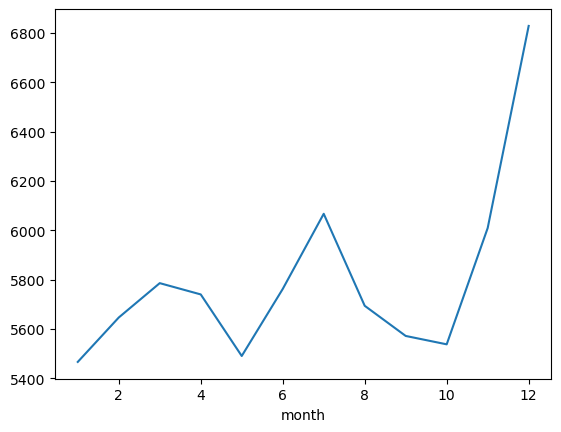

In [36]:
df.groupby('month')['sales'].mean().plot()

We have two complete years of annual data, which should allow us to capture the yearly seasonality to some extent. However, the sharp year-end spike might pose a challenge from a modeling perspective. In Prophet, tuning the appropriate hyperparameters for the seaons and/or holiday could help address the spike. 

Since ARIMA models cannot natively handle multiple seasonalities, we might consider using monthly dummy variables as exogenous regressors. Alternatively, I could decompose the time series (e.g., using MSTL), model the resulting remainder series with ARIMA, and then add the resulting forecasts together. However, given the objective of the exercise and the fact that actual forecasts are not required for the end of the year, I will ignore this phenomenon in the ARIMA models.

# Modeling

## Data Split

In [40]:
# I proceed with a subset of all stores.
stores = df.store.unique().tolist()
random.seed(42)
sample = random.sample(stores, 50)

In [41]:
df_sampe = df.query('store in @sample').copy()

In [42]:
df_train = df_sampe.query('date < "2015-05-01" & store < 30000').copy()

In [43]:
df_val = df_sampe.query('date >= "2015-05-01" & date < "2015-06-15" & store < 30000').copy()

In [44]:
df_test = df_sampe.query('date >= "2015-06-15" & store < 30000').copy()

In [45]:
stores = df_train.store.unique().tolist()

## Helper Functions

To improve readability, bug fixing, and maintainability, I define functions outside of the modeling loop.

In [48]:
# Data Preperation
def prepare_data(ts_id, df_train, df_val, df_test):
    # Filter data 
    training = df_train[df_train["store"] == ts_id].copy()
    validation = df_val[df_val["store"] == ts_id].copy()
    test = df_test[df_test["store"] == ts_id].copy()

    # Target variables
    y_train_log = training["log_sales"]
    y_train = training["sales"]

    # Dataset lengths
    val_len = len(validation)
    test_len = len(test)

    # Short Saturday Fix. As argued above, only some Saturdays have shorter business hours. In these cases, the dummy doesnt add any value. 
    if training.query('dayofweek == 6').sales.mean() < 0.8 * training.query('dayofweek < 6').sales.mean(): # Assumption: Saturdays are only shorter if the Saturday mean is less than 80%. 
        features = ['promo', 'short_day', 'close', 'pre_close', 'post_close']
    else:
        features = ['promo', 'close', 'pre_close', 'post_close']

    # Extract exogenous variables
    X_train = training[features]
    X_val = validation[features]
    X_test = test[features]

    return y_train, y_train_log, X_train, X_val, X_test, training, validation, test, val_len, test_len, 

In [49]:
# A dictionary to compute and store the error metric. This will be used for the ensemble weights.
def append_error_metric(metrics_list, store_id, model_name, df, actual_col, forecast_col):
    df = df[df[actual_col] != 0] # Closed days should be ignored in the computation of the error metric. The forecasts are set to zero post processing, see below  
    mape = mean_absolute_percentage_error(df[actual_col],df[forecast_col])
    metrics_list.append({
        "store":     store_id,
        "model":     model_name,
        "error_val": mape,
    })

In [50]:
# Naive Forecast (Benchmark)
def naive_fc(y_train,df_out,target_col, leng,mask):
    model_naive = skt.NaiveForecaster(strategy = 'mean', sp = 7, window_length = 14) # Use the mean value of previous two weeks (day of the week) to capture weekly season
    model_naive.fit(y_train)
    fc_naive = model_naive.predict(fh = np.arange(1,leng+1))
    df_out.loc[mask, target_col] = fc_naive

In [51]:
# Fit & Validation ARIMA Models
## The hyperparameter space is chosen to be somewhat parsimonious to reduce computational cost 
def arima_model(y_train,X_train,X_val,n_periods):
    model = pmd.auto_arima(y = y_train, X = X_train, seasonal = True,  max_p = 2, max_q = 2, max_d = 1, m = 7, max_P = 1, max_Q = 1, max_D = 1)
    pred_arima = model.predict(n_periods = n_periods, X = X_val)
    return model, pred_arima

In [6]:
360 * 500

180000

In [52]:
# ARIMA Predictions
def arima_fc(arima_model,y_val,X_val, X_test,df_out, target_col, leng, mask, logs: bool = False):
    arima_model.update(y_val, X_val) 
    fc_arima = arima_model.predict(n_periods = leng, X = X_test)
    if logs:
        fc_arima = np.exp(fc_arima)
    df_out.loc[mask, target_col] = fc_arima

As mentioned in the introduction, I update the model parameters using the full training dataset (i.e., both training and validation data). Hence, the model structure is determined based solely on the *training data*.

In [54]:
# Tune Prophet hyperparameters
## I do not attempt to tune all Prophet hyperparameters. Instead, I focus on those that likely have the greatest impact (changepoint_prioer_scale & seasonality_prior_scale, see Prophet documentation). 
## Furthermore, I allow for an additive and mulitplicative season. The approach can easily be extended to include more hyperparameters.
cps_list = [0.001,.05,.5]
sps_list = [0.01,1,10] 
season_list = ['additive','multiplicative'] #,'multiplicative'
def prophet_model(df_p, exo_regressors, cps_list, sps_list,season_list, initial_days):
    prophet_parameters = []
    all_combinations = itertools.product(cps_list,sps_list,season_list)
    for scale,season_scale,season_mode in all_combinations:
        prophet_m = Prophet(changepoint_prior_scale = scale, seasonality_prior_scale = season_scale, seasonality_mode = season_mode) #'additive'
        prophet_m.add_country_holidays(country_name = 'Germany')
        for reg in exo_regressors:
            prophet_m.add_regressor(reg)
        prophet_m.fit(df_p)
        
        df_cv = cross_validation(prophet_m, horizon='40 days', initial=initial_days, period='120 days', parallel="processes")      
        df_nz = df_cv[df_cv['y'] != 0].copy() # Zero sales values are dopped for Mape computation
        df_nz['pe'] = np.abs((df_nz['yhat'] - df_nz['y'])/ df_nz['y'])
        mape_by_fold = df_nz.groupby('cutoff')['pe'].mean() 
        mape_mean = mape_by_fold.mean() # Mape without zero sales. Equal weights for each horizon/fold
        
        prophet_parameters.append({
            'changepoint_prior_scale': scale,
            'seasonality_prior_scale': season_scale,
            'seasonality_mode': season_mode,
            'acc_metric': mape_mean 
        })
    
    best_prophet_parameters = min(prophet_parameters, key=lambda x: x['acc_metric'])
    return best_prophet_parameters

In [55]:
# Fit the best Prophet model and add predictions
def prophet_fit (df_p, exo_regressors, best_prophet_parameters, X_future, df_out, target_col, leng):
    # Model fit
    prophet_model = Prophet(changepoint_prior_scale = best_prophet_parameters['changepoint_prior_scale'], seasonality_prior_scale = best_prophet_parameters['seasonality_prior_scale'], seasonality_mode = best_prophet_parameters['seasonality_mode'])
    prophet_model.add_country_holidays(country_name = 'Germany')
    for reg in exo_regressors:
        prophet_model.add_regressor(reg)
    prophet_model.fit(df_p)

    # Future DF & Predictioncs
    future = prophet_model.make_future_dataframe(periods = leng, include_history = False)
    future[exo_regressors] = X_future[exo_regressors].to_numpy()
    
    fc_prophet = prophet_model.predict(future)['yhat'].to_numpy()
    return fc_prophet

Similar to the ARIMA models, the validation data is only used to update the model parameters.

In [57]:
# ETS
## I will use logs in the ETS models and assume the seasonality is known such that we only need check models with a (damped) trend. 
## Notice that the determination is based on information criteria (in-sample fit). 
## I could drop Sundays and use a seasonal length of 6 days. 
def ets_model(df_in, n_periods): 
    ETS_parameters = []
    aicc_by_spec = {}
    valid_combinations = [(None, False), ("add", False), ("add", True)]

    for trend, damped in valid_combinations:
        model = ETSModel(endog = df_in['log_sales'],error = 'add', seasonal = 'add', trend = trend, damped_trend = damped, seasonal_periods = 7) 
        res = model.fit()
        aicc_by_spec[(trend, damped)] = float(res.aicc)
    best_trend, best_damped = min(aicc_by_spec, key=aicc_by_spec.get)
    model = ETSModel(endog = df_in['log_sales'],error = 'add', seasonal = 'add', trend = best_trend, damped_trend = best_damped, seasonal_periods = 7).fit()
    pred_ets = model.forecast(steps = n_periods) 
    return model, pred_ets, best_trend, best_damped

## Forecast Loop

In [59]:
forecast_available = False

In [60]:
#sample = sample[0:1]

In [61]:
if forecast_available:
    df_forecast = pd.read_csv('forecasts.csv')
else:
    val_metrics = [] 
    weights_list = []
    start = time.time()
    i = 0
    for ts_id in sample:
        i += 1
        #print('start:', time.strftime('%H:%M:%S', time.localtime()), 'ts_id:', ts_id, ', Count:',i )
        y_train, y_train_log, X_train, X_val, X_test, training, validation, test, val_len, test_len,  = prepare_data(ts_id, df_train, df_val, df_test)
       
        #### Model Training and Validation ####
    
        ## ARIMA Log    
        model_log, pred_arima_log = arima_model(y_train_log.to_numpy(),X_train.to_numpy(),X_val.to_numpy(),val_len)
        validation['fc_arima_log'] = np.where(X_val.close == 1, 1, np.exp(pred_arima_log))  # No bias adjustment 
        append_error_metric(val_metrics,ts_id,"ARIMA_log",validation,"sales","fc_arima_log")

        ## ETS
        model_ets, pred_ets, best_trend, best_damped = ets_model(df_in = training, n_periods = val_len)
        validation['fc_ets'] = np.where(validation['close'] == 1, 1, np.exp(pred_ets))   # No bias adjustment 
        append_error_metric(val_metrics,ts_id,"ETS",validation,"sales","fc_ets")
        
        ## Prophet
        exo_cols = X_train.columns.tolist()
        df_p = training.rename(columns={'date':'ds','sales':'y'}).copy()
        final_cols = ['ds', 'y'] + exo_cols
        df_p = df_p[final_cols]
    
        best_prophet_parameters = prophet_model(df_p = df_p, cps_list = cps_list, sps_list = sps_list, season_list = season_list, exo_regressors = exo_cols, initial_days = '540 days')
        fc_prophet_val = prophet_fit(df_p = df_p, best_prophet_parameters = best_prophet_parameters,  X_future = X_val, exo_regressors = exo_cols, df_out = validation, target_col = 'fc_prophet', leng = val_len)
        validation['fc_prophet'] = np.where(X_val.close == 1, 1, fc_prophet_val)
        append_error_metric(val_metrics,ts_id,"Prophet",validation,"sales","fc_prophet")
    
        #### Update Model Parameters & Forecasts ####
        mask = df_test["store"] == ts_id
    
        ## Naive Forecast
        naive_fc(y_train = validation.sales.to_numpy(), df_out = df_test, target_col = 'fc_naive', leng = test_len, mask = mask)
        
        ## Arima
        arima_fc(model_log, y_val = validation.log_sales.to_numpy(), X_val = X_val.to_numpy(), X_test = X_test.to_numpy(),df_out = df_test, target_col = 'fc_arima_log', leng = test_len, mask = mask, logs = True)

        ## ETS
        df_ets = pd.concat([training, validation], ignore_index=True).query('dayofweek != 7')
        ets_model_update = ETSModel(endog = df_ets['log_sales'], error = 'add', seasonal = 'add', trend = best_trend, damped_trend = best_damped, seasonal_periods = 7).fit()    
        df_test.loc[mask,'fc_ets'] = np.exp(ets_model_update.forecast(steps = test_len)).to_numpy()
        
        ## Prophet
        X_full = pd.concat([X_train, X_val], ignore_index=True)   
        df_p_full = pd.concat([training, validation], ignore_index=True).rename(columns={'date':'ds', 'sales':'y'})
        final_cols = ['ds', 'y'] + exo_cols
        df_p_full = df_p_full[final_cols]
        
        fc_prophet_test = prophet_fit(df_p = df_p_full, best_prophet_parameters = best_prophet_parameters,  X_future = X_test, exo_regressors = exo_cols, df_out = df_test, target_col = 'fc_prophet',leng = test_len)
        df_test.loc[mask,'fc_prophet'] = fc_prophet_test
        
        ## Set Forecasts to zero if closed
        cols = ['fc_naive','fc_prophet','fc_arima_log','fc_ets']
        closed_mask = (df_test['store'].eq(ts_id)) & (df_test['close'].eq(1))
        df_test.loc[closed_mask, cols] = 0
    
        #### Ensemble ####
    
        error_val = 'error_val'
        ensemble_weights = pd.DataFrame(val_metrics).query("store == @ts_id").assign( # and model != 'Naive'
                 score=lambda df: 1/(df[error_val] + 1e-9),
                 weight=lambda df: df['score']/df['score'].sum())
        
        weights = ensemble_weights.set_index('model')['weight'].to_dict()
    
        df_test.loc[mask, "fc_ensemble"] = weights['Prophet'] * df_test.loc[mask,'fc_prophet'] + weights['ETS'] * df_test.loc[mask,'fc_ets']  + weights['ARIMA_log'] * df_test.loc[mask,'fc_arima_log']
        weights['ts_id'] = ts_id
        weights_list.append(weights)
    end = time.time()
    elapsed_minutes = round((end - start) / 60, 2)
    elapsed_minutes
    
    # Only consider stores for which forecasts were made and business days
    df_forecast = df_test.query('fc_naive.notna() & sales != 1').copy()
    df_forecast.to_csv('forecasts.csv', index = False)

# Forecast Evaluation

In [63]:
results = df_forecast.groupby('store').apply(
    lambda df: pd.Series({
        'fc_naive': mean_absolute_percentage_error(df['sales'], df['fc_naive']),
        'fc_arima_log': mean_absolute_percentage_error(df['sales'], df['fc_arima_log']),
        'fc_prophet': mean_absolute_percentage_error(df['sales'], df['fc_prophet']),
        'fc_ets': mean_absolute_percentage_error(df['sales'], df['fc_ets']),
        'fc_ensemble': mean_absolute_percentage_error(df['sales'], df['fc_ensemble']),
    })
).reset_index()

C:\Users\flel8\AppData\Local\Temp\ipykernel_4356\3933853608.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df_forecast.groupby('store').apply(


In [64]:
results[['fc_naive','fc_arima_log','fc_prophet','fc_ets','fc_ensemble']].mean().sort_values()

fc_arima_log   0.099
fc_prophet     0.103
fc_ensemble    0.103
fc_naive       0.240
fc_ets         0.334
dtype: float64

In [107]:
cols = [c for c in results.columns if c.startswith('fc_')]
results['best_forecast'] = results[cols].idxmin(axis=1)

In [109]:
results.best_forecast.value_counts()

best_forecast
fc_arima_log    21
fc_ensemble     16
fc_prophet      13
Name: count, dtype: int64

We see that the ARIMA (log) and Prophet models perform similarly. The ETS model, however, performs very poorly, even trailing the Naive forecast. This suggests it struggles to capture the seasonality and closed-day effects. Since ETS cannot incorporate exogenous regressors, it may not be well-suited for this problem. Expanding the hyperparameter space and/or exploring a different season (6 days) in the ETS model might help, but this is beyond the scope of this exercise.

The ensemble model performs slightly worse than ARIMA and Prophet. This is not surprising, as it is partially influenced by the ETS model. In principle, an ensemble should improve both robustness and accuracy. To achieve the latter, at least one class of models needs to perform well on certain series (and thus receive a higher weight), while others perform better on different series, so that the combination yields overall accuracy gains. We see no evidence of this effect here.

A possible reason is that the ensemble weights were derived from a single validation set. A particular model may have been “lucky” in that set, leading to overfitting of the weights. Another explanation could be high correlation in model errors. If all models tend to perform well or poorly on the same series, combining them will not improve accuracy.

Let’s examine the correlation of the errors to investigate this further.

In [116]:
errors = pd.DataFrame({
    'arima_log': df_forecast['fc_arima_log'] - df_forecast['sales'],
    'prophet':   df_forecast['fc_prophet']   - df_forecast['sales'],
    'ETS': df_forecast['fc_ets'] - df_forecast['sales']
})

In [118]:
corr_matrix = errors.corr()
print(corr_matrix)

           arima_log  prophet   ETS
arima_log      1.000    0.899 0.490
prophet        0.899    1.000 0.383
ETS            0.490    0.383 1.000


Indeed, the Prophet and ARIMA models error's are highly correlated, calling for a more diverse selection of models (e.g. N-Beats). A brief look at the weights reveals that the ETS models indeed have an effect.

In [133]:
df_val = pd.DataFrame(val_metrics)

df_val['score'] = 1 / (df_val['error_val'] + 1e-9)
df_val['weight'] = df_val['score'] / df_val.groupby('store')['score'].transform('sum')

In [141]:
avg_weights = df_val.groupby('model')['weight'].mean()
avg_weights

model
ARIMA_log   0.431
ETS         0.147
Prophet     0.422
Name: weight, dtype: float64

Cross validation might help to filter out “lucky” validation runs and reduce the ETS weights. However, it is unlikely that it will be a game changer given the correlation of the models error's. I will explore cross validation in the next iteration. 